In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time
from scipy.ndimage.measurements import label
from sklearn.model_selection  import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from random import randint
from frame import Frame
from vehicle import Vehicle

In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

X_scaler = None
svc = None

ystart = 400
ystop = 656
scale = 1.5
sizes = ((32,32), (64,64), (128,128))
heatmap_threshold = 1

In [3]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    global frame_no
    frame_no = frame_no + 1
    
    frame  = Frame()
    frame.detected = False
    frame.no = frame_no
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        frame.detected = True
        vehicle  = Vehicle()
        vehicle.setValues(np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy))
        frame.vehicle.append(vehicle)
        
        # Draw the box on the image
        if(len(frames) > 9):
            oldFrames = frames[-10:]
            count = 0
            for oldFrame in oldFrames:
                for oldVehicle in oldFrame.vehicle:                    
                    checkminx = oldVehicle.avgx - 15
                    checkmaxx = oldVehicle.avgx + 15
                    checkminy = oldVehicle.avgy - 15
                    checkmaxy = oldVehicle.avgy + 15
                    if(((checkminx <= vehicle.avgx <= checkmaxx) and (checkminy <= vehicle.avgy <= checkmaxy))):
                        count = count + 1

                if(count >= 3):
                       cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
                   
        else:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image
    frames.append(frame)
    return img

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

    
def draw_image(car_image, noncar_image):
    fig = plt.figure(figsize=(8, 6))
    plt.subplot(121)
    plt.imshow(car_image, cmap='gray')
    plt.title('Car')    
    plt.subplot(122)
    plt.imshow(noncar_image, cmap='gray')
    plt.title('Not-Car')
    plt.show()

In [13]:
def train(debug = False):
    images = glob.glob('vehicles\**\*.png', recursive=True)
    cars = []
    notcars = []
    for image in images:
        cars.append(image)

    images = glob.glob('non-vehicles\**\*.png', recursive=True)
    for image in images:
        notcars.append(image)

    #cars = cars[0:100]
    #notcars = notcars[0:100]
    print('Number of vehicles:', len(cars))
    print('Number of Non vehicles:', len(notcars))
    
    if(debug):
        carIndex = randint(0,len(cars)-1)
        nocarIndex = randint(0,len(notcars)-1)
        car_image = mpimg.imread(cars[carIndex])
        notcar_image = mpimg.imread(notcars[nocarIndex])
        draw_image(car_image, notcar_image)
        x, car_img = get_hog_features(cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        y, notcar_img = get_hog_features(cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY), orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        draw_image(car_img, notcar_img)

        car_img = convert_color(car_image, conv='RGB2YCrCb')
        notcar_img = convert_color(notcar_image, conv='RGB2YCrCb')
        
        draw_image(car_img[:,:,0], notcar_img[:,:,0])
        draw_image(car_img[:,:,1], notcar_img[:,:,1])
        draw_image(car_img[:,:,2], notcar_img[:,:,2])




    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    global X_scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    global svc
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, sizes, debug = False):
    t=time.time()
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            for size in sizes:
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], size)

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                #X_scaler = StandardScaler().fit(X)
                test_features = X_scaler.transform(X)    
                 #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    t2 = time.time()
    if debug == True:
        print(round(t2-t, 2), 'Seconds to find car...')
    return window_list

def test():    
    
    images = glob.glob('test_images/*.jpg')
    for image in images:
        img = mpimg.imread(image)
        window_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, sizes, True)
        out_img = draw_boxes(img, window_list)

        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,window_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,heatmap_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)

        fig = plt.figure(figsize=(16, 12))
        plt.subplot(131)
        plt.imshow(out_img)
        plt.title('All Identifications')    
        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.subplot(133)
        plt.imshow(draw_img)
        plt.title('Car Positions')        
        fig.tight_layout()


    plt.show()

In [6]:
def process_image(img):

    window_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, sizes)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,window_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

Number of vehicles: 8792
Number of Non vehicles: 8968


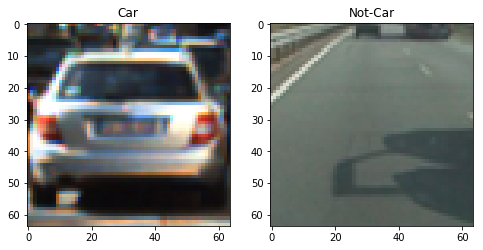

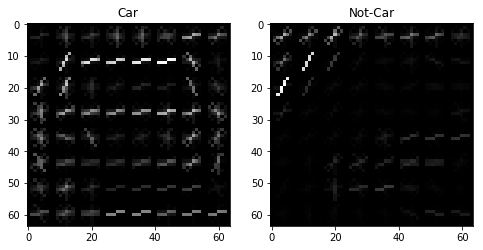

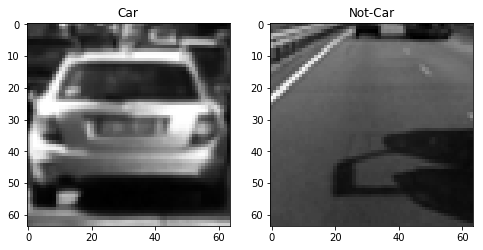

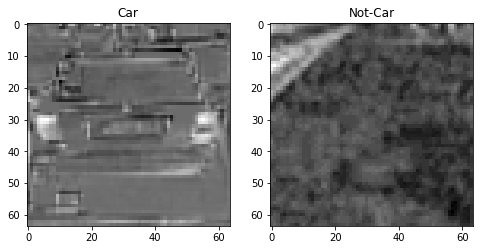

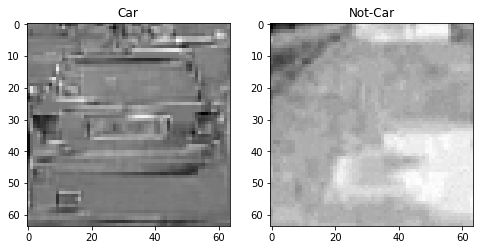

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
13.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


In [7]:
train(debug=True)

1.23 Seconds to find car...
1.03 Seconds to find car...
1.51 Seconds to find car...
1.16 Seconds to find car...
1.45 Seconds to find car...
1.03 Seconds to find car...
1.25 Seconds to find car...


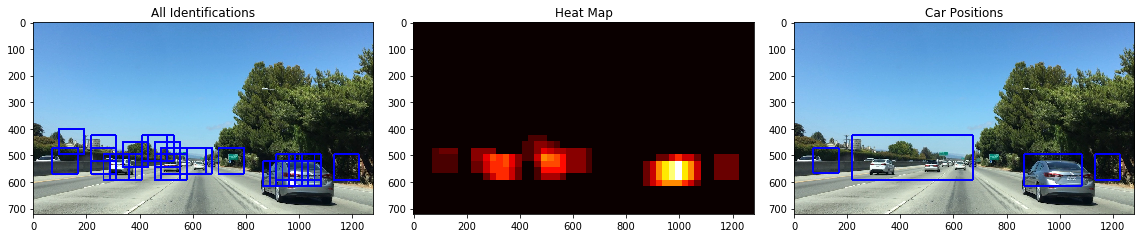

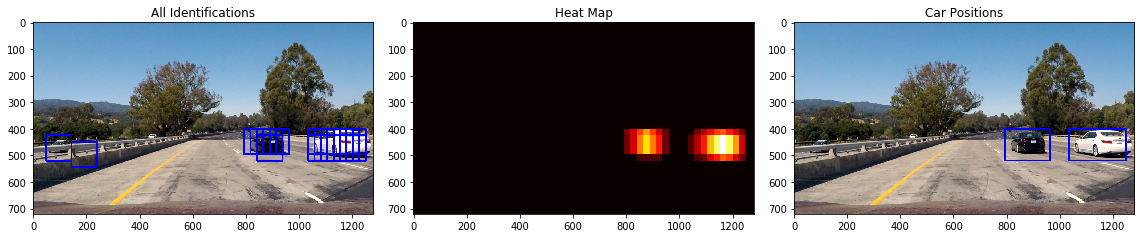

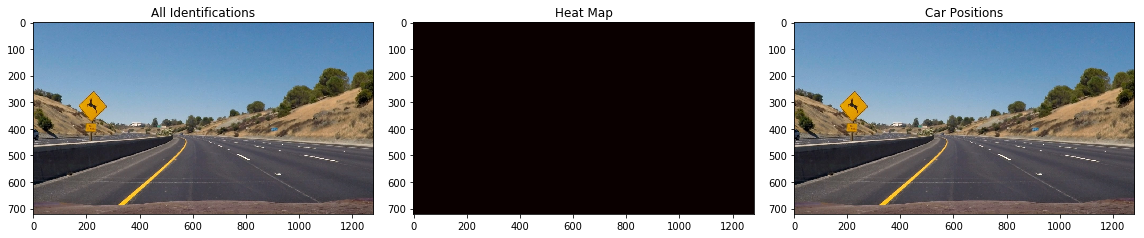

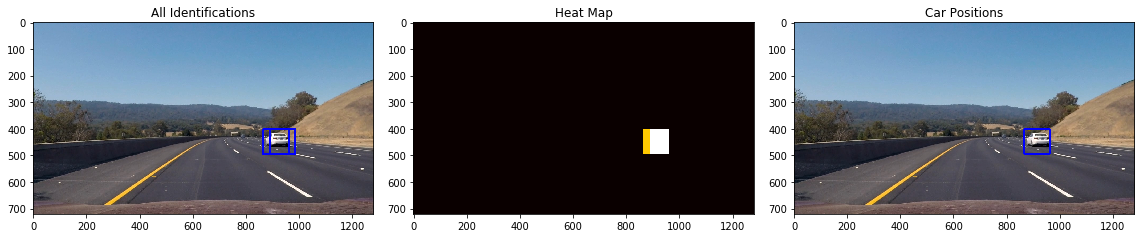

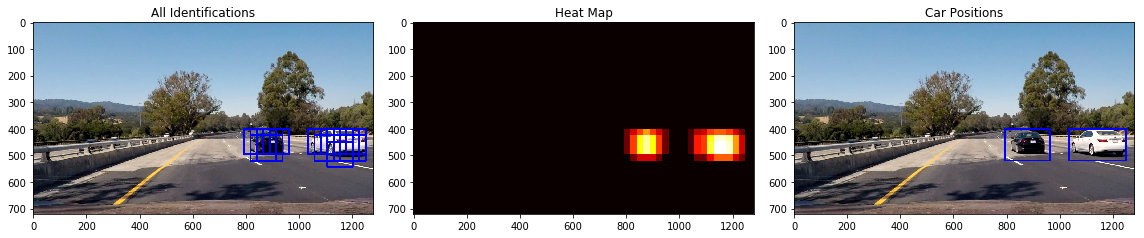

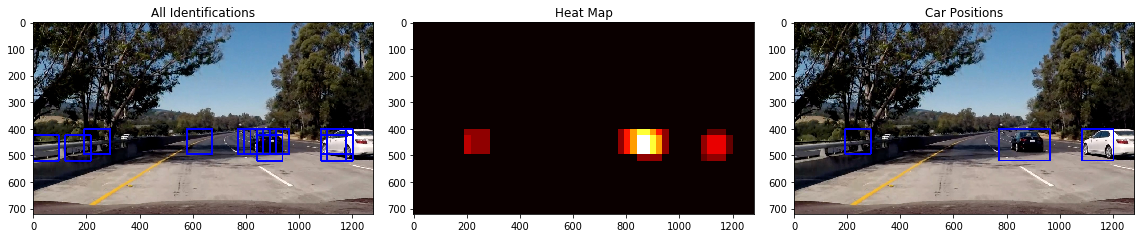

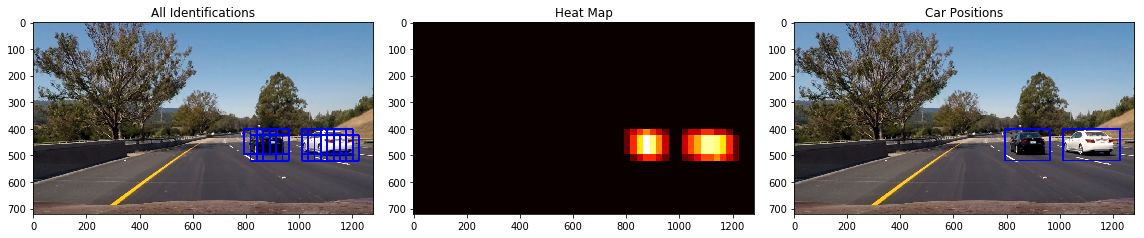

In [14]:
frame_no = 0
frames = list()

test()

In [10]:
frame_no = 0
frames = list()

output_file = 'output.mp4'
vclip = VideoFileClip("project_video.mp4")
out_clip = vclip.fl_image(process_image).subclip(t_start=0, t_end=50) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_file, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1250/1251 [29:25<00:01,  1.48s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 29min 28s
